## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import kagglehub
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [4]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rahul\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [ ]:
# Data path

dataset_path = os.path.join(path, "/Users/rahul/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1")

# List files in the dataset directory

files = os.listdir(dataset_path)

print("Files in dataset directory:", files)

Files in dataset directory: ['Meta', 'Meta.csv', 'ResizedTrain', 'Test', 'Test.csv', 'Train', 'Train.csv']


In [6]:
data_dir = "/Users/rahul/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
train_path = '/Users/rahul/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train'
test_path = '/Users/rahul/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [10]:
df = pd.read_csv(os.path.join(dataset_path, "Train.csv"))

df_test = pd.read_csv(os.path.join(dataset_path, "Test.csv"))

meta = pd.read_csv(os.path.join(dataset_path, "Meta.csv"))


## Understand the Data
Our goal is to use the training set to determine the different categories of traffic signs. The Meta folder has 42 categories, also labeled on the train set. Let's first display that category and then display some training samples.

In [11]:
print("Training dataset:")

print(df.head())

Training dataset:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [12]:
print("\nTest dataset:")

print(df_test.head())


Test dataset:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [13]:
print("\nMeta dataset:")

print(meta.head())


Meta dataset:
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22


In [15]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

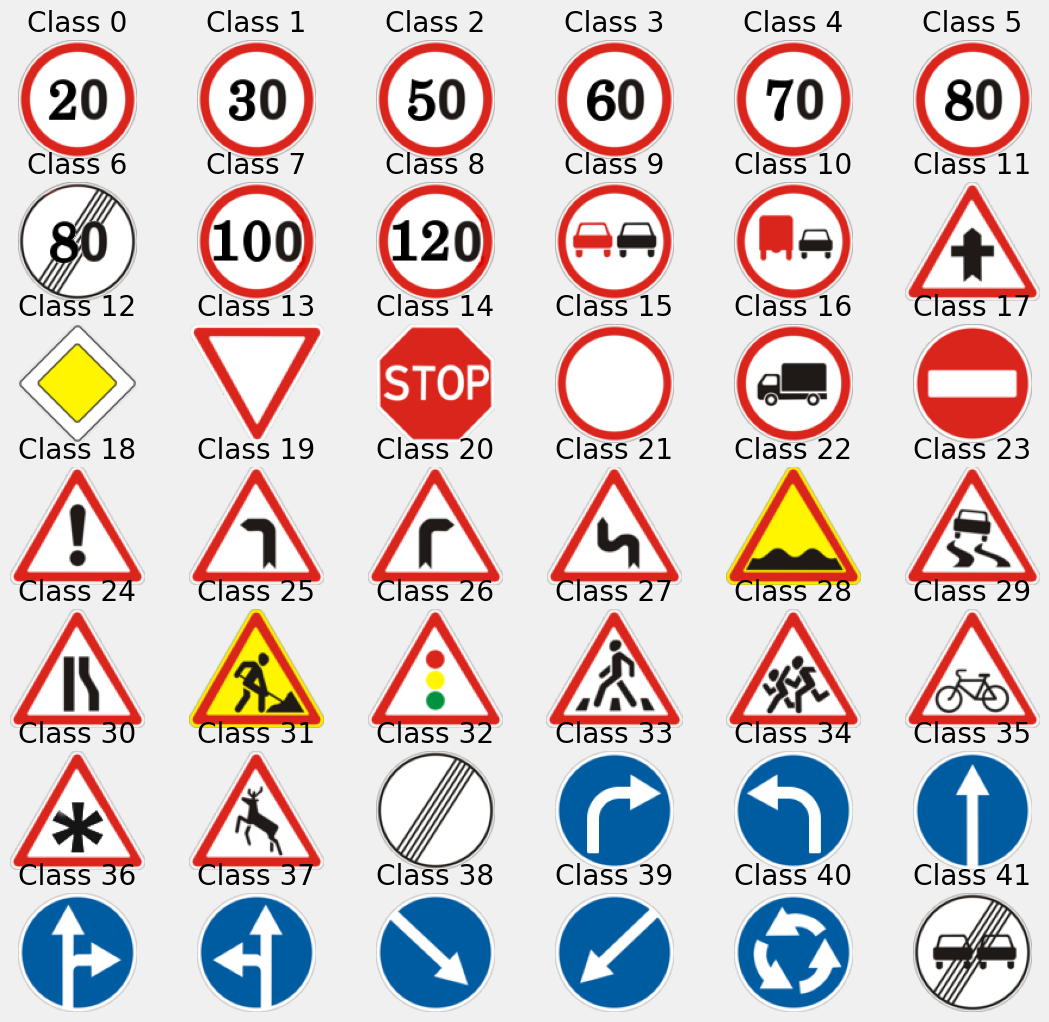

In [14]:
# Show all 42 images in meta dataset

# Rank the classes from 0 to 42 before displaying

meta_sorted = meta.sort_values(by="ClassId").reset_index(drop=True)

fig, axs = plt.subplots(7, 6, figsize=(12, 12))

for i in range(42):

    img_path = os.path.join(dataset_path, meta_sorted.iloc[i]["Path"])
    img = Image.open(img_path)

    axs[i // 6, i % 6].imshow(img)

    axs[i // 6, i % 6].axis("off")

    axs[i // 6, i % 6].set_title(f"Class {meta_sorted.iloc[i]["ClassId"]}")

plt.show()

In [8]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

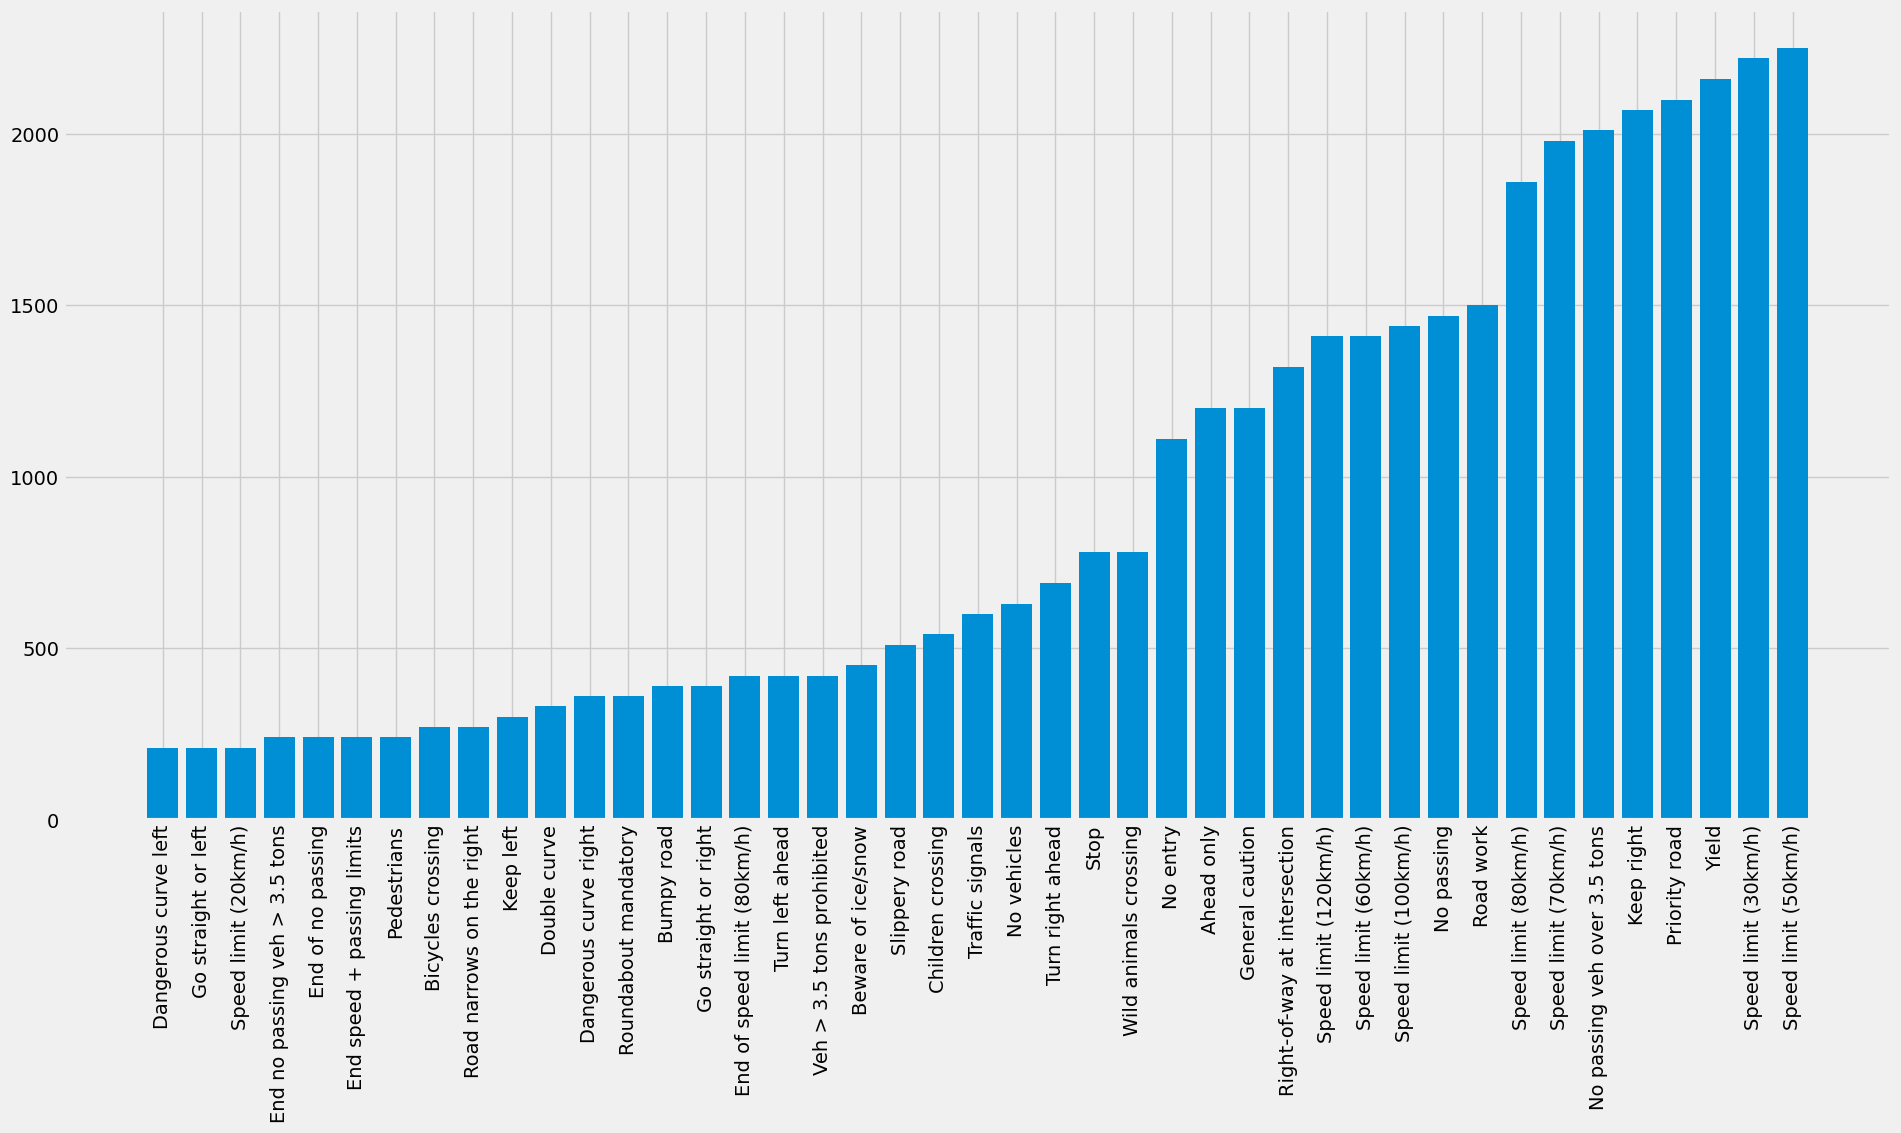

In [9]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Visualizing 25 random images from test data

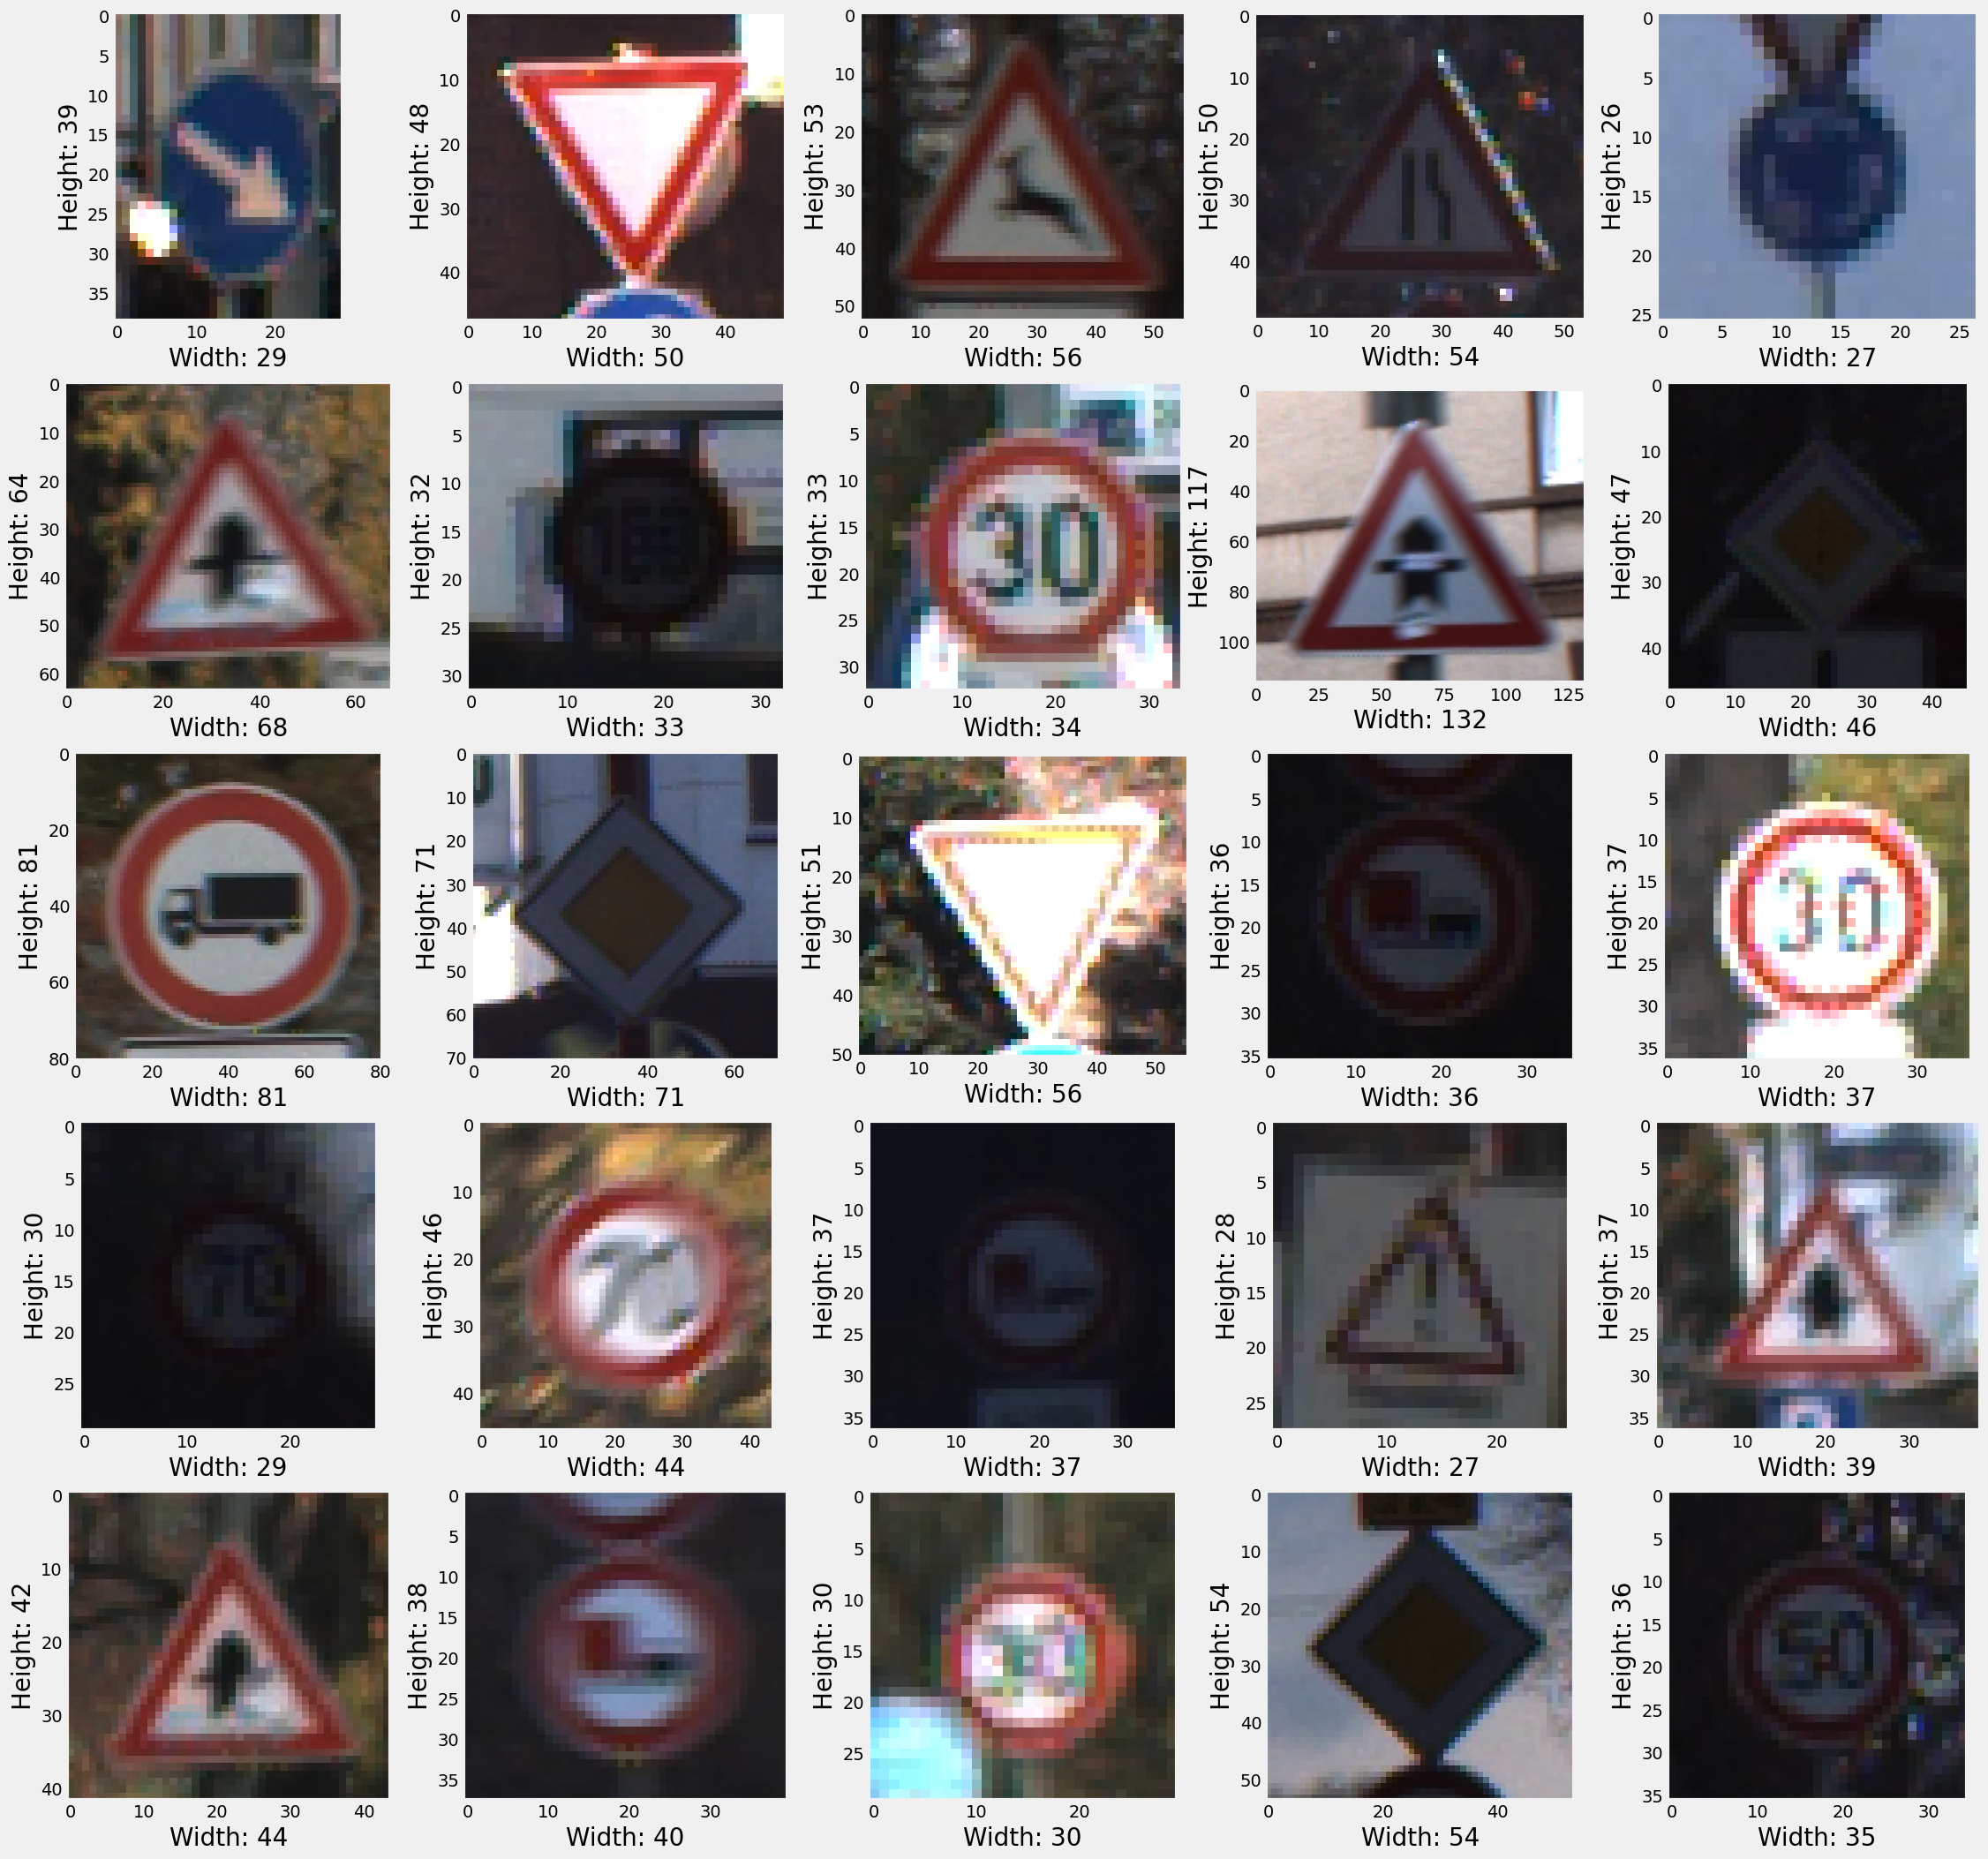

In [18]:
import random
from matplotlib.image import imread

# Assuming data_dir is already defined and points to the correct directory
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)  # Turn off the grid
    plt.xlabel(f"Width: {rand_img.shape[1]}", fontsize=20)  # width of image
    plt.ylabel(f"Height: {rand_img.shape[0]}", fontsize=20)  # height of image

plt.show()


## Collecting the Training Data

In [19]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [20]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [21]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [22]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [23]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
from tensorflow.keras.optimizers import Adam

lr = 0.001
epochs = 30
# Correct the argument names
opt = Adam(learning_rate=lr)  # Remove decay, use learning_rate instead
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Augmenting the data and training the model

In [26]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.4864 - loss: 2.1191 - val_accuracy: 0.9475 - val_loss: 0.1736
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9315 - loss: 0.2223 - val_accuracy: 0.9858 - val_loss: 0.0482
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9609 - loss: 0.1318 - val_accuracy: 0.9908 - val_loss: 0.0314
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9753 - loss: 0.0838 - val_accuracy: 0.9677 - val_loss: 0.0987
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9747 - loss: 0.0844 - val_accuracy: 0.9738 - val_loss: 0.0879
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9742 - loss: 0.0876 - val_accuracy: 0.9860 - val_loss: 0.0442
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9839 - loss: 0.0498 - val_accuracy: 0.9877 - val_loss: 0.0397
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9803 - loss: 0.0629 - 

In [27]:
model.save("model.h5")

In [30]:
model.save_weights("/Users/rahul/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/output.weights.h5")

In [31]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize'

## Evaluating the model

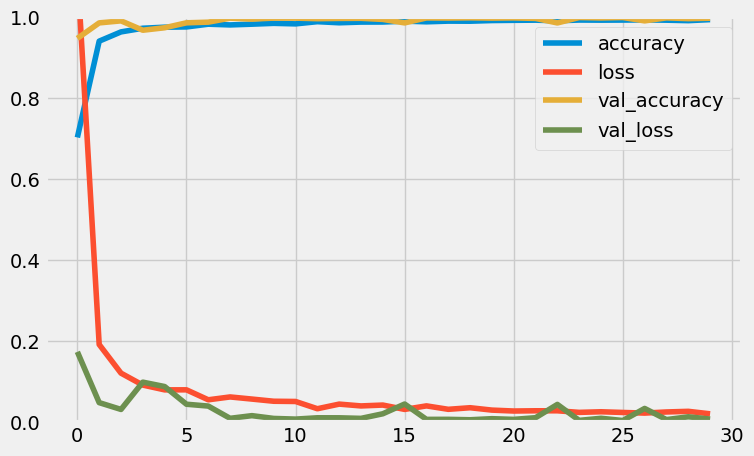

In [32]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [34]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# Predict the class probabilities for each image
pred_prob = model.predict(X_test)

# Get the class labels by taking the argmax of the predicted probabilities
pred = np.argmax(pred_prob, axis=1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Data accuracy:  97.96516231195565


## Visualizing the confusion matrix

In [35]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

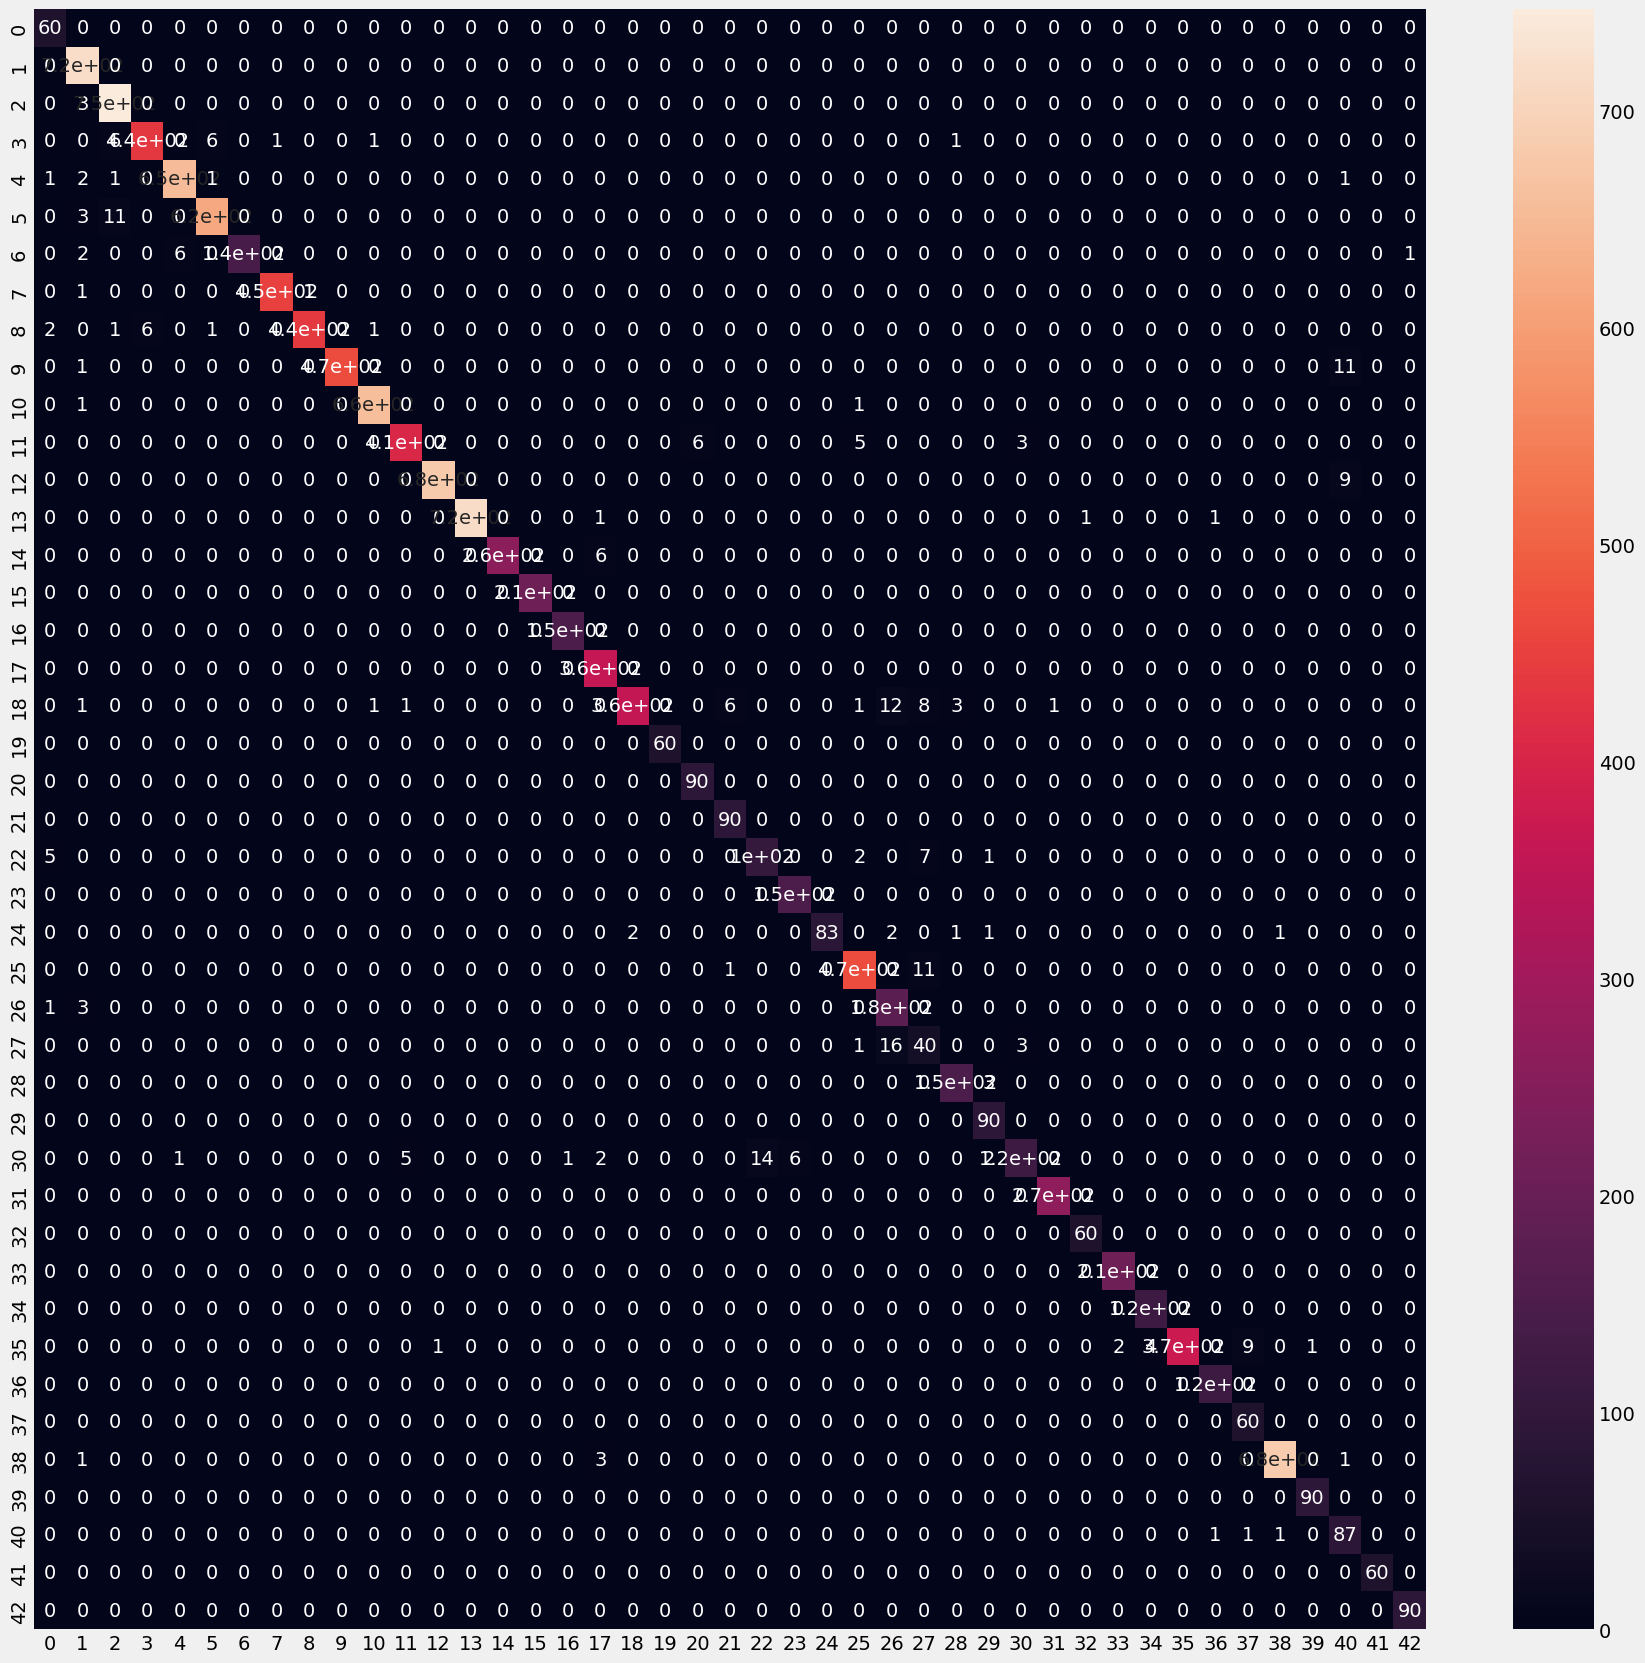

In [36]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [37]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.98      1.00      0.99       720
           2       0.98      1.00      0.99       750
           3       0.99      0.97      0.98       450
           4       0.99      0.99      0.99       660
           5       0.99      0.98      0.98       630
           6       1.00      0.94      0.97       150
           7       1.00      1.00      1.00       450
           8       1.00      0.98      0.99       450
           9       1.00      0.97      0.99       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      0.98      0.99       270
          15       1.00      1.00      1.00       210
          16       0.99      1.00      1.00       150
          17       0.97    

## Predictions on Test Data

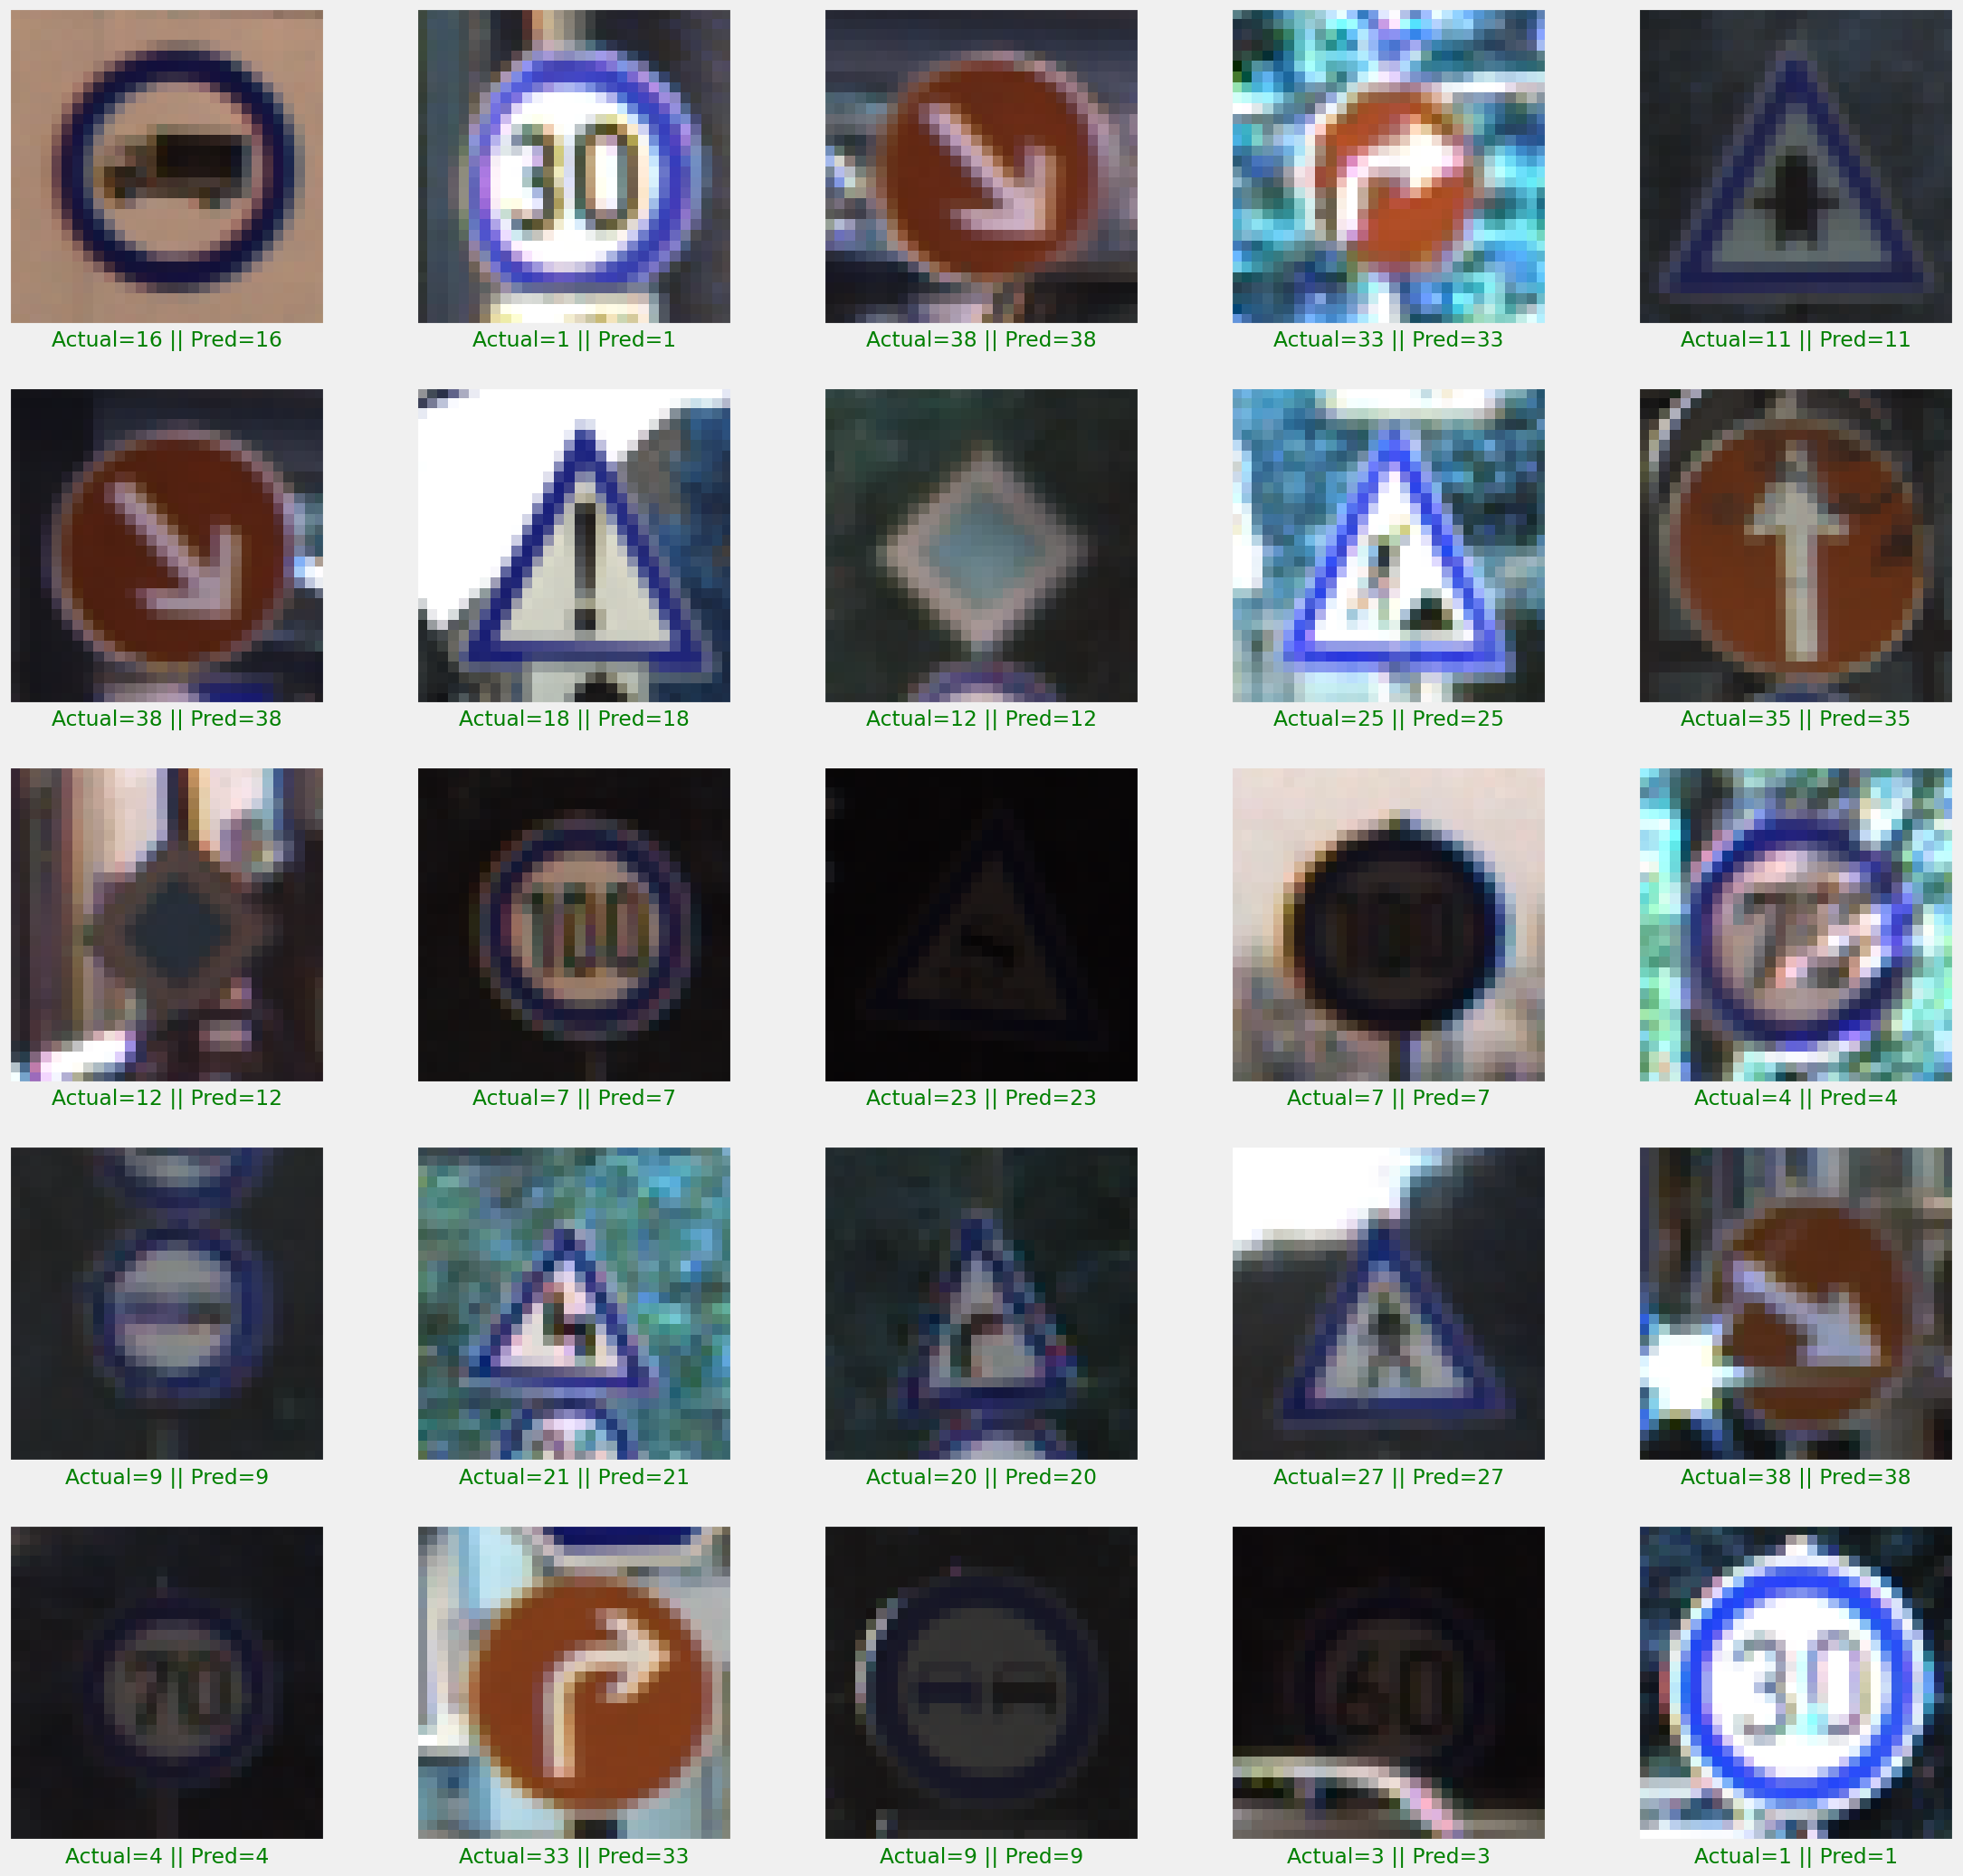

In [38]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [39]:
ls

 Volume in drive C is OS
 Volume Serial Number is 8A4F-0AFF

 Directory of c:\Users\rahul\Desktop\SEM 5\DL Lab

11/17/2024  04:43 AM    <DIR>          .
11/17/2024  01:13 AM    <DIR>          ..
11/17/2024  01:13 AM    <DIR>          .dist
11/17/2024  04:13 AM         3,241,362 ClassifyingTrafficSigns.ipynb
10/12/2024  05:44 AM           186,733 Deep Learning Theory+Lab.pdf
11/17/2024  04:43 AM        14,125,200 model.h5
11/17/2024  03:50 AM         1,127,689 Model_training.ipynb
11/17/2024  04:48 AM         1,694,484 Traffic.ipynb
               5 File(s)     20,375,468 bytes
               3 Dir(s)  637,988,425,728 bytes free


In [ ]:
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

image = cv2.imread("3.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


38